In [1]:
import aiida

# must execute it in the first place
aiida.load_profile()


In [2]:
from aiida.orm import Code
from aiida.orm import Str, Int, Dict, List
from aiida.engine import calcfunction, WorkChain, ToContext, append_
from aiida.plugins import DataFactory, WorkflowFactory
from itertools import cycle
import os
from tools import wait_for_node_finished
from aiida.engine import calcfunction, workfunction, submit, run, run_get_node
from aiida.orm import load_code, load_node

# load types
StructureData = DataFactory('structure')
FolderData = DataFactory('folder')
SinglefileData = DataFactory('singlefile')
ArrayData = DataFactory('array')
List = DataFactory('list')


In [3]:
# codeの定義を行う。
from tools.aiida_support import get_or_create_local_computer, get_or_create_code
from os.path import expanduser
import os
home = expanduser("~")
work_directory = os.path.join(home, 'aiida')
computer_local = get_or_create_local_computer(work_directory, 'localhost')

if True:
    code = get_or_create_code('alamode.alm_opt',
                              computer_local,
                              '/home/max/Documents/alamode/bin/alm')
    code_alm_opt = code
else:
    code_alm_opt = WorkflowFactory('alamode.alm_ALM_opt')


code = get_or_create_code('alamode.anphon',
                          computer_local,
                          '/home/max/Documents/alamode/bin/anphon')
code_anphon = code

code_alm_opt, code_anphon


(<Code: Remote code 'alamode.alm_opt' on localhost, pk: 2434, uuid: 96d86443-33b4-4ded-8101-27900dcefe48>,
 <Code: Remote code 'alamode.anphon' on localhost, pk: 2435, uuid: 5df33ce6-9f81-45f0-b607-1f4459e4f841>)

In [4]:
import json
with open("setting.json") as f:
    _dic = json.load(f)
print(_dic)
CWD = _dic["CWD"]
_path = os.path.abspath(CWD)
os.makedirs(_path, exist_ok=True)
_path


{'CWD': 'run35'}


'/home/max/Documents/aiida-alamode_public/example/run35'

In [5]:
from os.path import expanduser
from tools import NodeBank

# 再実行時に作成したノードを用いるためにnodebankを使う。
g_force = False
nodebank = NodeBank(_path, force=g_force)


In [6]:
g_cwd = nodebank.load("cwd")
#g_dispfile_folder = nodebank.load("dispfile_folder")
#g_displace_result = nodebank.load("displace_result")
g_superstructure = nodebank.load("superstructure")
g_standardizedstructure = nodebank.load("standardizedstructure")


In [7]:
g_prefix = nodebank.load('prefix')
g_norder = nodebank.load(f"{g_prefix.value}_norder")
g_factor = nodebank.load('factor')
g_prefix, g_norder, g_factor.get_array('factor')


(<Str: uuid: 43812d12-3c45-4981-8877-26f40299b550 (pk: 3587) value: harmonic>,
 <Int: uuid: 5f617e93-0c19-4c8c-859b-b490418f9a8b (pk: 3588) value: 1>,
 array([[2, 0, 0],
        [0, 2, 0],
        [0, 0, 2]]))

# alm opt 
```
Description:

	alm mode="opt"
	
	default input filename: alm_opt.in
	default output filename: alm_opt.out
	
	if 'cwd' is given. The retrieved files will be saved in the directory specified by 'cwd'.

Inputs:
             code:  required  Code                  The `Code` to use for this job.
            dfset:  required  List                  DFSET
           norder:  required  Int                   1 (harmonic) or 2 (cubic)
        structure:  required  StructureData         structure of cyrstal.
           cutoff:  optional  Dict                  distance cutoff
              cwd:  optional  Str                   directory where results are saved.
           fc2xml:  optional  List, SinglefileData  xml file for the cubic term
         metadata:  optional                        
             mode:  optional  Str                   mode of alm='opt'
            param:  optional  Dict                  optional parameters
           prefix:  optional  Str                   string added to the filename.
Outputs:
  force_constants:  required  List, SinglefileData  force constants.
     input_ANPHON:  required  List, SinglefileData  ANPHON file
    remote_folder:  required  RemoteData            Input files necessary to run the process will be stored in this folder node ...
          results:  required  Dict                  
        retrieved:  required  FolderData            Files that are retrieved by the daemon will be stored in this node. By defa ...
     remote_stash:  optional  RemoteStashData       Contents of the `stash.source_list` option are stored in this remote folder ...


```

In [8]:
g_alamodeextract_future = nodebank.load(f'{g_prefix.value}_extract')


In [9]:
g_DFSET = g_alamodeextract_future.outputs.dfset
g_DFSET

<List: uuid: 361da35d-84ea-4c92-80e4-7aba9ab27426 (pk: 3637) value: ['# Filename: 0.in, Snapshot: 1', '    0.01889726124994     0.00000000000000     0.00000000000000      -6.18122950E-03 -0.00000000E+00 -0.00000000E+00', '    0.00000000000000     0.00000000000000     0.00000000000000       0.00000000E+00  0.00000000E+00 -0.00000000E+00', '    0.00000000000000     0.00000000000000     0.00000000000000      -9.27929864E-05 -1.10300393E-05 -1.10300393E-05', '    0.00000000000000     0.00000000000000     0.00000000000000       0.00000000E+00 -0.00000000E+00  0.00000000E+00', '    0.00000000000000     0.00000000000000     0.00000000000000       7.16560485E-06  1.13725071E-05 -3.09293101E-05', '    0.00000000000000     0.00000000000000     0.00000000000000      -0.00000000E+00  0.00000000E+00  0.00000000E+00', '    0.00000000000000     0.00000000000000     0.00000000000000       7.16560485E-06 -3.09293101E-05  1.13725071E-05', '    0.00000000000000     0.00000000000000     0.00000000000000  

In [10]:
codetype = "calculation"
try:
    if issubclass(code_alm_opt, WorkChain):
        codetype = "workchain"
except TypeError:
    codetype = "calculation"


if codetype == "workchain":
    print("workchain")
    code = code_alm_opt

    inputs = {"structure": g_superstructure,  # 　安定構造
              "cwd": Str(os.path.join(g_cwd.value, f"{g_prefix.value}_opt")),
              "cutoff_radii": List(list=[[-1]]),
              "nbody": List(list=[[2]]),
              "norder":  g_norder,
              "dfset": g_DFSET}

    key = f'{g_prefix.value}_ALM_opt'
    g_almoptfuture = nodebank.load(key, raise_error=False)
    if g_almoptfuture is None:
        g_almoptfuture = submit(code_alm_opt, **inputs)
        print(g_almoptfuture)
        wait_for_node_finished(g_almoptfuture)
        nodebank.dump(key, g_almoptfuture)

else:
    print("code")
    code = code_alm_opt

    builder = code.get_builder()
    builder.structure = g_superstructure  # 　安定構造
    builder.cwd = Str(os.path.join(g_cwd.value, f"{g_prefix.value}_opt"))
    builder.norder = g_norder
    builder.dfset = g_DFSET

    key = f'{g_prefix.value}_opt'


    g_almoptfuture = nodebank.load_code_or_wait_for_node(key, builder)



code
None
uuid: e5c97231-ab99-4e0d-94d4-292d8dc4087e (pk: 3643) (aiida.calculations:alamode.alm_opt)
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
True True
0:00:12.509033


In [11]:
node = load_node(2441)
node.attributes

{'state': 'parsing',
 'job_id': '11414',
 'sealed': True,
 'version': {'core': '1.6.9'},
 'withmpi': False,
 'exception': 'TypeError: StopIteration interacts badly with generators and cannot be raised into a Future',
 'resources': {'num_machines': 1, 'num_mpiprocs_per_machine': 1},
 'append_text': '',
 'checkpoints': '!plumpy:bundle\n\'!!meta\':\n  class_name: aiida_alamode.calculations.alm_calcjob:AlmOptCalculation\n  types:\n    _future: S\n  user:\n    object_loader: aiida.engine.persistence:ObjectLoader\nINPUTS_PARSED: "!plumpy:attributes_frozendict\\ncode: !aiida_node \'96d86443-33b4-4ded-8101-27900dcefe48\'\\n\\\n  cutoff: !aiida_node \'7371c42b-39d2-409e-9952-1aa72104bf44\'\\ncwd: !aiida_node \'f567824e-60fb-42c7-95e0-4358181ef40f\'\\n\\\n  dfset: !aiida_node \'f9ea1590-6659-4440-9c10-7bca4383a577\'\\nmetadata: !plumpy:attributes_frozendict\\n\\\n  \\  call_link_label: CALL\\n  dry_run: false\\n  options: !plumpy:attributes_frozendict\\n\\\n  \\    append_text: \'\'\\n    custom

In [12]:
g_almoptfuture.outputs.input_ANPHON.list_object_names()


['disp.xml']

In [13]:
nodebank.dump("anphonfile_xml", g_almoptfuture.outputs.input_ANPHON)


<SinglefileData: uuid: fff04c7f-db8f-4a58-a79a-8857a2209df0 (pk: 3647)>

# phonon dispersion

In [14]:
g_root_wd = nodebank.load("cwd")
g_almprefix = "_".join([g_prefix.value, "band"])
g_property = Str(os.path.join(g_root_wd.value, g_almprefix))
print(g_property)


uuid: 5122206a-ef53-4d06-8f6b-3e0ab5444351 (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_harmonic/harmonic_band


In [15]:
g_dispersionprefix = Str("band")
# os.makedirs(g_property.value, exist_ok=True)
g_primstructure = nodebank.load("primstructure")  # primitive cell


In [16]:
g_property, g_dispersionprefix


(<Str: uuid: 5122206a-ef53-4d06-8f6b-3e0ab5444351 (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_harmonic/harmonic_band>,
 <Str: uuid: 372ea005-7206-4345-8dc6-c98614bc838a (unstored) value: band>)

# alamode.anphon
```
Description:

	anphon.
	
	mode can be 'phonons' and 'RTA'.
	
	for mode=='phonons', phonons_mode can be 'band' and 'dos'.
	
	Default k-points are [20,20,20] for dos.
	
	If 'cwd' is given. The retrieved files will be saved in the directory specified by 'cwd'.

Inputs:
           code:  required  Code                  The `Code` to use for this job.
         fcsxml:  required  SinglefileData, List  Probably it is input_ANPHON. It is used at norder=2.
      structure:  required  StructureData         primitive structure.
            cwd:  optional  Str                   directory where results are saved.
     kappa_spec:  optional  Int                   
       metadata:  optional                        
           mode:  optional  Str                   anphon mode
         norder:  optional  Int                   1 (harmonic) or 2 (cubic)
          param:  optional  Dict                  additional parameters
   phonons_mode:  optional  Str                   phonon mode
         prefix:  optional  Str                   string added to filename.
          qmesh:  optional  List                  phonon k-mesh
Outputs:
             kl:  required  ArrayData             
        kl_file:  required  SinglefileData        
        kl_spec:  required  ArrayData             
   kl_spec_file:  required  SinglefileData        
    phband_file:  required  SinglefileData        
     phdos_file:  required  SinglefileData        
  remote_folder:  required  RemoteData            Input files necessary to run the process will be stored in this folder node ...
    result_file:  required  SinglefileData        
        results:  required  Dict                  
      retrieved:  required  FolderData            Files that are retrieved by the daemon will be stored in this node. By defa ...
    thermo_file:  required  SinglefileData        
   remote_stash:  optional  RemoteStashData       Contents of the `stash.source_list` option are stored in this remote folder ...


```

In [17]:
code = code_anphon

builder = code.get_builder()
builder.structure = g_primstructure
builder.prefix = g_dispersionprefix
builder.cwd = g_property
builder.fcsxml = g_almoptfuture.outputs.input_ANPHON
builder.mode = Str("phonons")
builder.phonons_mode = Str("band")

g_phbandfuture = nodebank.load_code_or_wait_for_node('phband', builder, sec=5)


None
uuid: 6062c3cd-0715-44fb-a093-39701add78bc (pk: 3657) (aiida.calculations:alamode.anphon)
wait another 5 sec.
wait another 5 sec.
True True
0:00:10.386589


In [18]:
g_phbandfuture.outputs.phband_file


<SinglefileData: uuid: 382655a9-f222-4969-90ec-de81ac45664b (pk: 3660)>

# phonon DOS

In [19]:
# from alamode_aiida.alm_input import make_alm_uniform_kmesh
# g_qmesh_value = make_alm_uniform_kmesh(g_primstructure.get_ase(),kspacing=0.001)
g_qmesh = List(list=[10, 10, 10])  # qmeshの定義
g_qmesh.get_list()


[10, 10, 10]

In [20]:
g_almprefix = "_".join(["harmonic", "dos",
                       "q"+"x".join(map(str, g_qmesh.get_list()))
                        ])
g_property = Str(os.path.join(g_root_wd.value, g_almprefix))
print(g_almprefix)

g_dosprefix = Str("dos")
g_property, g_dosprefix


harmonic_dos_q10x10x10


(<Str: uuid: 82c0527a-655a-4b17-bcd5-1216ca24f4fb (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_harmonic/harmonic_dos_q10x10x10>,
 <Str: uuid: 72399176-97a1-42f3-8645-31d40915e875 (unstored) value: dos>)

In [21]:
#codename = "anphon@tutor"
#code = Code.get_from_string(codename)
code = code_anphon

builder = code.get_builder()
builder.structure = g_primstructure
builder.prefix = g_dosprefix
builder.cwd = g_property
builder.fcsxml = g_almoptfuture.outputs.input_ANPHON
builder.mode = Str("phonons")
builder.phonons_mode = Str("dos")
builder.qmesh = g_qmesh

g_phdosfuture = nodebank.load_code_or_wait_for_node('phdos', builder, sec=5)


None
uuid: 32d0dca2-8f25-4890-956e-fc1c9e5cb0b2 (pk: 3670) (aiida.calculations:alamode.anphon)
wait another 5 sec.
wait another 5 sec.
True True
0:00:10.455079


In [22]:
g_phdosfuture.outputs.phdos_file


<SinglefileData: uuid: 33d1a927-088c-43b6-980f-dcd728a6b7e2 (pk: 3673)>

# plot dispersion

```
Description:

	Phonon band workchain.
	
	band_filenames should support valid_type (SinglefileData, FolderData).
	
	cwd must be supplied because the external alamode python script will be executed.
	External alamode python scripts are not integrated, as they will change with version upgrades.
	
	band_file must be absolute full path if they are Str or List.

Inputs:
     band_file:  required  Str, List, SinglefileData  phonon band filenames
           cwd:  required  Str                        directory where results are saved.
        prefix:  required  Str                        string added to filenames.
  img_filename:  optional  Str                        image filename
      metadata:  optional                             
      unitname:  optional  Str                        unit of energy
Outputs:
      img_file:  required  SinglefileData             image file
    
```

In [23]:
g_almprefix = "_".join([g_prefix.value, "band_img"])
g_property = Str(os.path.join(g_root_wd.value, g_almprefix))
print(g_property)


uuid: 95e00ed6-8626-475f-bc3d-072f636fa203 (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_harmonic/harmonic_band_img


In [24]:
g_band_filenames = g_phbandfuture.outputs.phband_file
g_band_filenames, g_dispersionprefix


(<SinglefileData: uuid: 382655a9-f222-4969-90ec-de81ac45664b (pk: 3660)>,
 <Str: uuid: 372ea005-7206-4345-8dc6-c98614bc838a (pk: 3649) value: band>)

In [25]:
phbandworkchain = WorkflowFactory('alamode.phband_img')
inputs = {"cwd": g_property, 
          "band_file": g_band_filenames, "prefix": g_dispersionprefix}
print(inputs)


{'cwd': <Str: uuid: 95e00ed6-8626-475f-bc3d-072f636fa203 (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_harmonic/harmonic_band_img>, 'band_file': <SinglefileData: uuid: 382655a9-f222-4969-90ec-de81ac45664b (pk: 3660)>, 'prefix': <Str: uuid: 372ea005-7206-4345-8dc6-c98614bc838a (pk: 3649) value: band>}


In [26]:
phbandimgworkchain = submit(phbandworkchain, **inputs)
print(phbandimgworkchain)
wait_for_node_finished(phbandimgworkchain)
if not phbandimgworkchain.is_finished_ok:
    raise


uuid: 62329afc-216b-4d8b-a331-6758c2fa82ef (pk: 3679) (aiida.workflows:alamode.phband_img)
wait another 2 sec.
True True


In [27]:
phbandimgworkchain.outputs.img_file


<SinglefileData: uuid: 1c23d05c-a8ec-4690-90df-61772d218a03 (pk: 3681)>

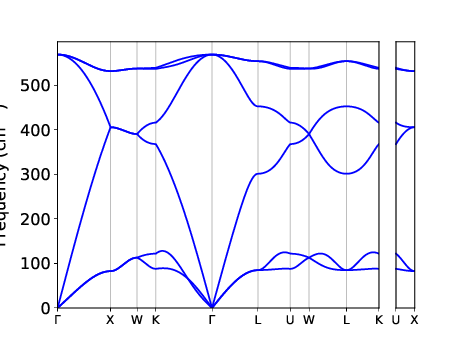

In [28]:
from wand.image import Image as WImage
filename = os.path.join(g_property.value, phbandimgworkchain.outputs.img_file.filename)
img = WImage(filename=filename)
img


filename_img = '/home/max/Documents/alamode-aiida/example/run32/Ga2N2_2x0x0x0x2x0x0x0x2_harmonic/harmonic_band_img/band_phband.pdf'


# plot DOS

```
Description:

	Phonon DOS workchain.
	
	dos_filenames should support valid_type (SinglefileData, FolderData).

Inputs:
           cwd:  required  Str                        directory where results are saved.
      dos_file:  required  Str, List, SinglefileData  phonon dos
        prefix:  required  Str                        string added to filenames
  img_filename:  optional  Str                        image filename
      metadata:  optional                             
      unitname:  optional  Str                        unit of energy
Outputs:
      img_file:  required  SinglefileData             image file

```


In [29]:
g_almprefix = "_".join(["harmonic", "dos_img",
                       "q"+"x".join(map(str, g_qmesh.get_list()))
                        ])
g_property = Str(os.path.join(g_root_wd.value, g_almprefix))
print(g_property)


uuid: a1acf15b-251f-4522-98fd-31f629cab81c (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_harmonic/harmonic_dos_img_q10x10x10


In [30]:
phdosworkchain = WorkflowFactory('alamode.phdos_img')

inputs = {"cwd": g_property, 
    "dos_file": g_phdosfuture.outputs.phdos_file,
          "prefix": g_dosprefix}
print(inputs)

g_dosfuture = submit(phdosworkchain, **inputs)
print(g_dosfuture)
wait_for_node_finished(g_dosfuture)
if not g_dosfuture.is_finished_ok:
    raise


{'cwd': <Str: uuid: a1acf15b-251f-4522-98fd-31f629cab81c (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_harmonic/harmonic_dos_img_q10x10x10>, 'dos_file': <SinglefileData: uuid: 33d1a927-088c-43b6-980f-dcd728a6b7e2 (pk: 3673)>, 'prefix': <Str: uuid: 72399176-97a1-42f3-8645-31d40915e875 (pk: 3662) value: dos>}
uuid: 98ac58a2-8639-462c-986b-a51e8f4ad954 (pk: 3685) (aiida.workflows:alamode.phdos_img)
wait another 2 sec.
True True


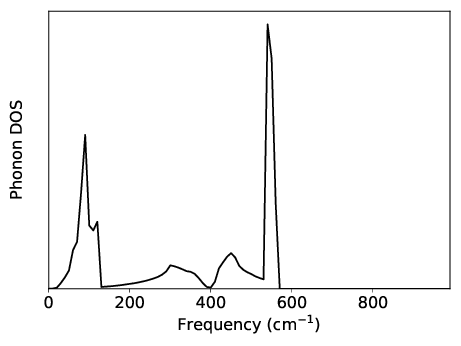

In [31]:
from wand.image import Image as WImage
filename = os.path.join(g_property.value, g_dosfuture.outputs.img_file.filename)
img = WImage(filename=filename)
img


## free energies
```
Description:

	generate free energy image

Inputs:
           cwd:  required  Str                  directory where files are saved.
        prefix:  required  Str                  string added to filenames
   thermo_file:  required  Str, SinglefileData  thermo file
  img_filename:  optional  Str                  image file template
      metadata:  optional                       
Outputs:
      img_file:  required  SinglefileData       image file

```

In [32]:
g_almprefix = "_".join(["harmonic", "freeenergy_img",
                       "q"+"x".join(map(str, g_qmesh.get_list()))
                        ])
g_property = Str(os.path.join(g_root_wd.value, g_almprefix))
print(g_property)


uuid: e32815c5-2ddc-4d07-8019-a56f9da4def1 (unstored) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_harmonic/harmonic_freeenergy_img_q10x10x10


In [33]:
FreeenergyImgWorkChain = WorkflowFactory("alamode.freeenergy_img")
g_inputs = {'cwd': g_property, 
    'prefix': g_dosprefix,
            'thermo_file': g_phdosfuture.outputs.thermo_file}


freeenergyimgfuture = submit(FreeenergyImgWorkChain, **g_inputs)
print(freeenergyimgfuture)
wait_for_node_finished(freeenergyimgfuture)
if not freeenergyimgfuture.is_finished_ok:
    raise


uuid: 926d3051-a020-479f-ae41-9696a00e724a (pk: 3690) (aiida.workflows:alamode.freeenergy_img)
wait another 2 sec.
True True


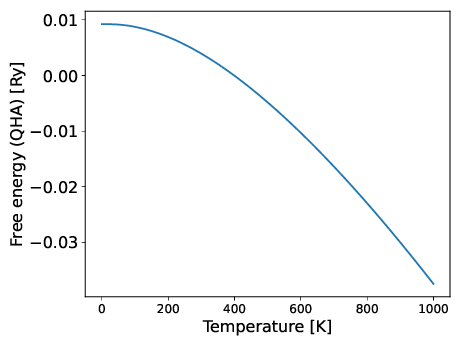

In [34]:
from wand.image import Image as WImage
filename = os.path.join(g_property.value, freeenergyimgfuture.outputs.img_file.filename)
img = WImage(filename=filename)
img


3643
Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 3643.dot.pdf


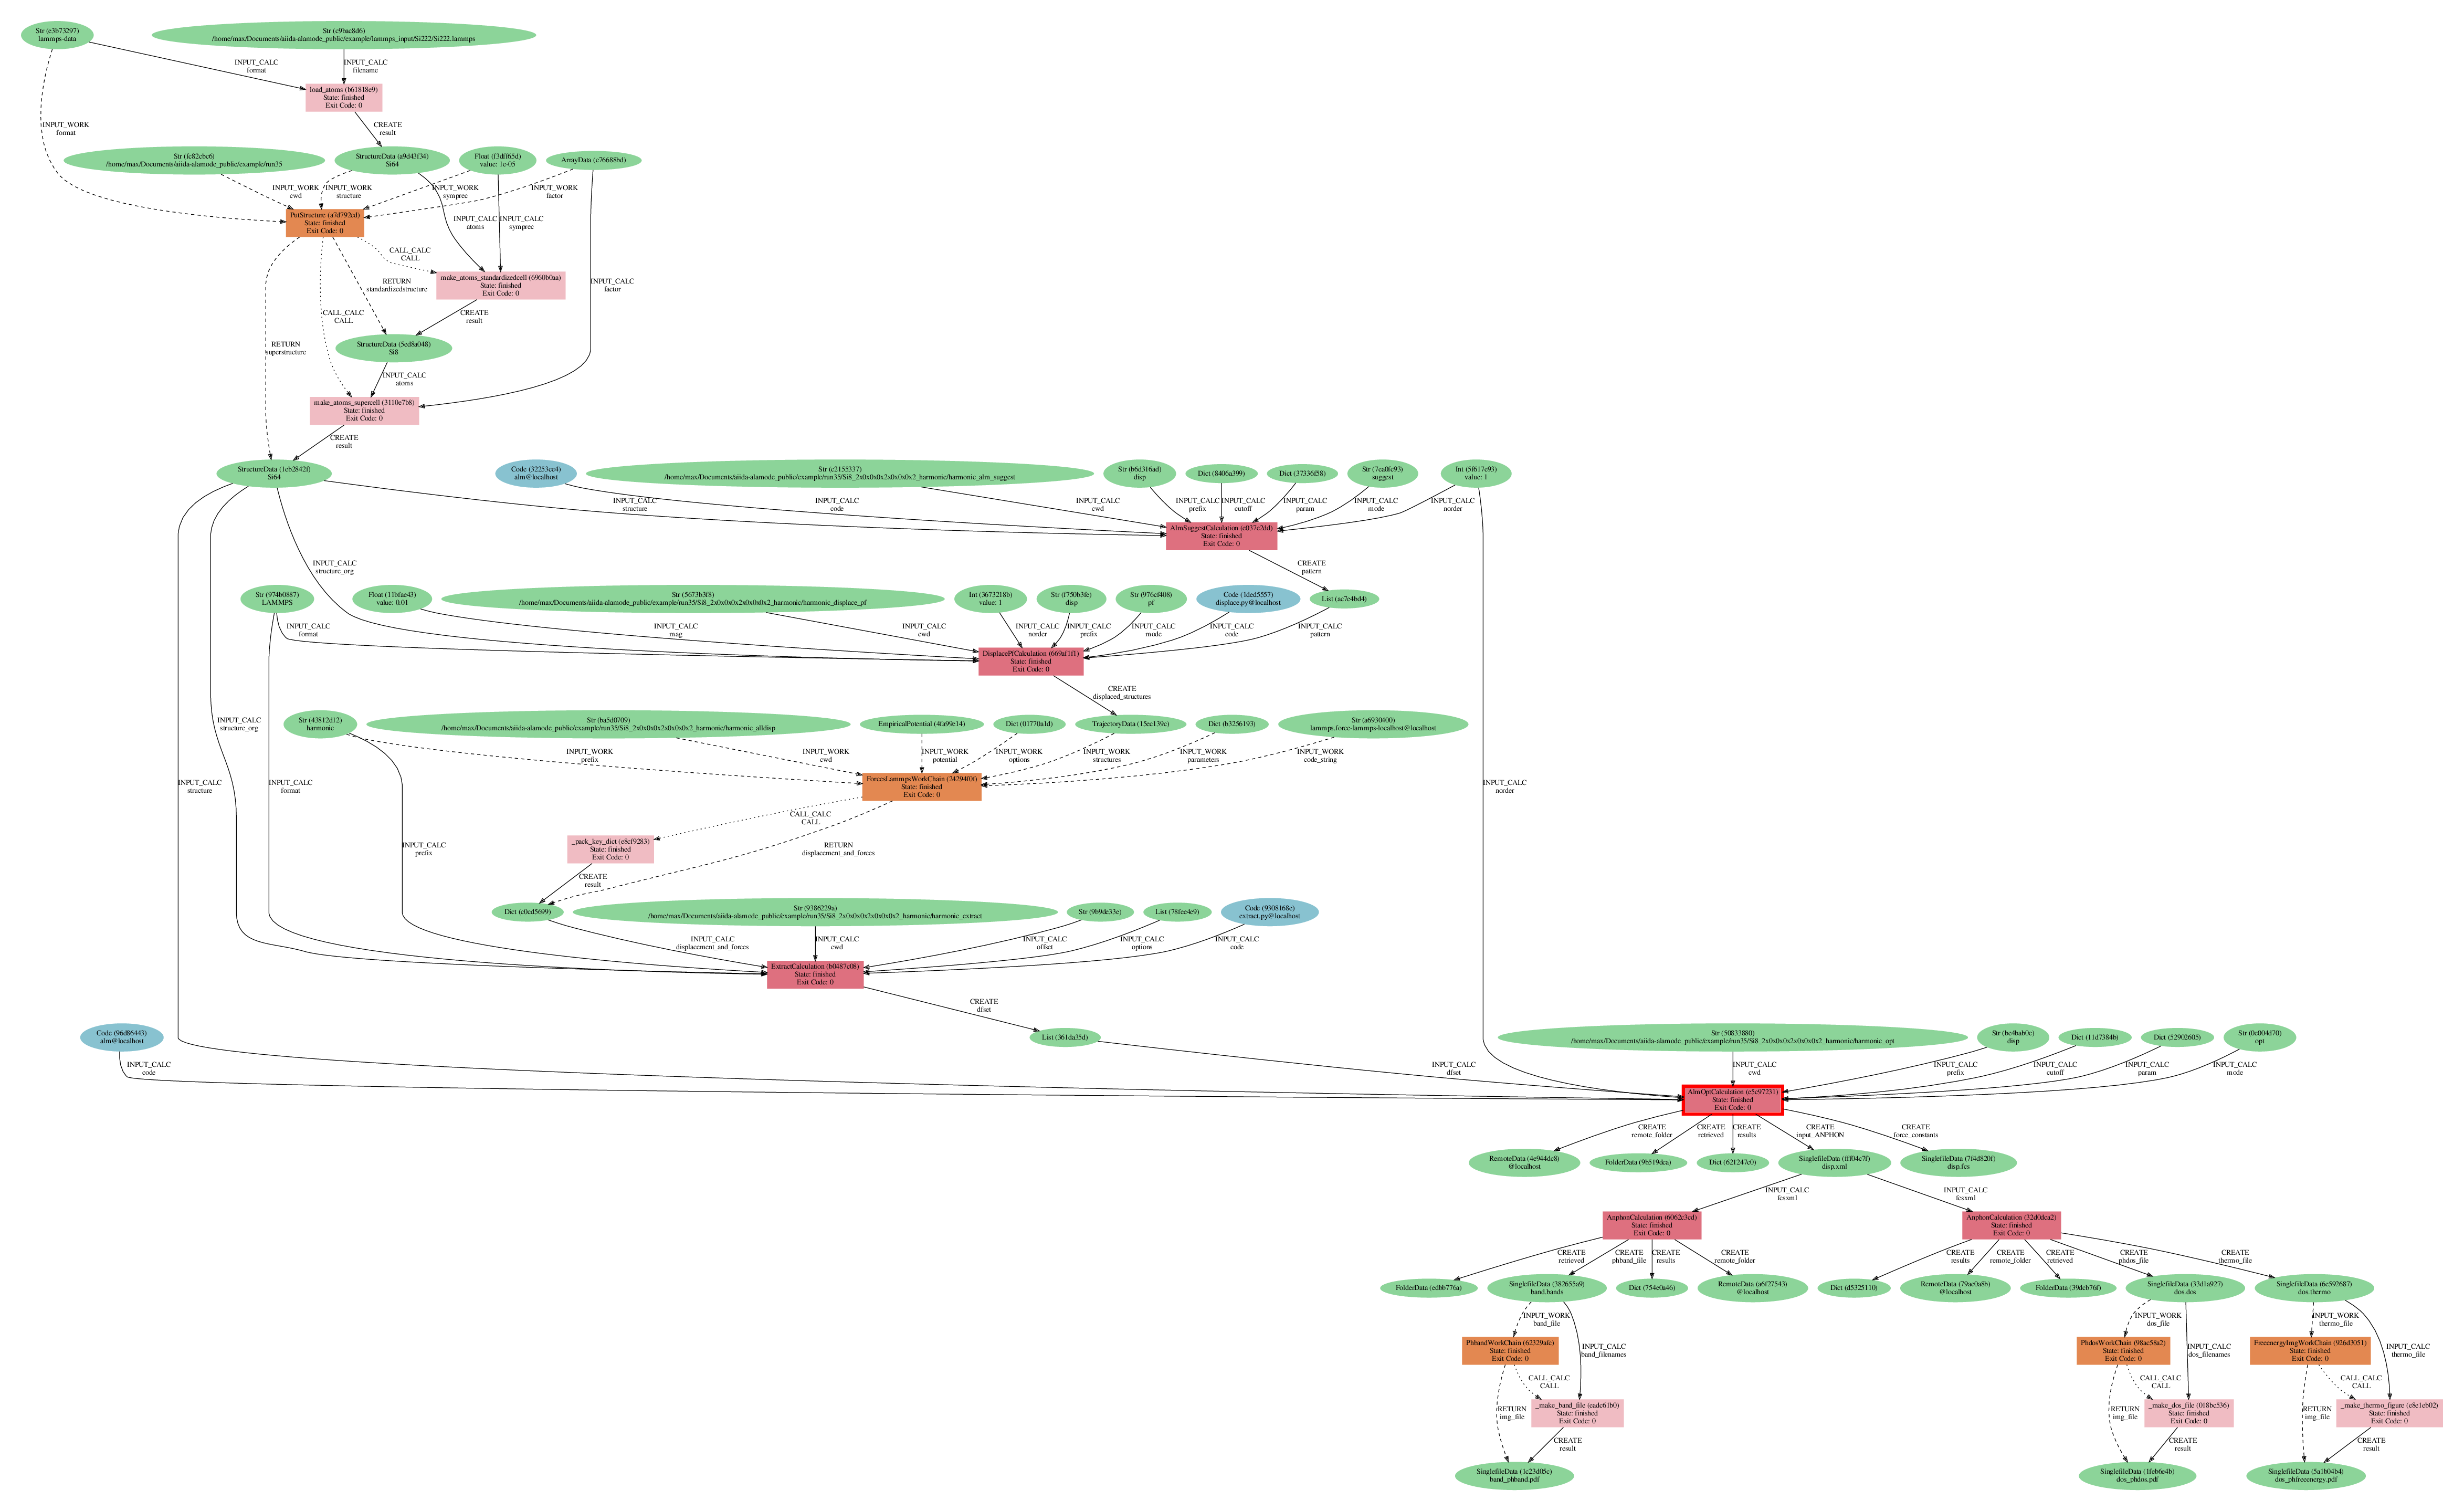

In [35]:
g_graph=True
if g_graph:
    pk = g_almoptfuture.pk
    print(pk)
    !verdi node graph generate $pk
    from wand.image import Image as WImage
    filename = f"{pk}.dot.pdf"
    img = WImage(filename=filename)
    display(img)
